# Importing data

In [1]:
#regex 
import re

#data manipulation:
import pandas as pd
import numpy as np

#nlp:
import nltk
import gensim

#language detection:
from langdetect import detect

# unidecode
import unidecode

# emoji support
import emoji

#spellchecker
from autocorrect import Speller

#tqdm for notebook progressbars
from tqdm.notebook import tqdm
tqdm.pandas() # pandas.progress_map & pandas.progress_apply 

# seeding numpy:
np.random.seed(2021)

In [5]:
"""
Topic modeling 
Tweets of the COVID_19
These tweets are collected using Twitter API and a Python script.
 A query for this high-frequency hashtag (#covid19) is run on a daily basis for a certain time period, to collect a larger number of tweets samples.
The tweets have #covid19 hashtag. Collection started on 25/7/2020, with an initial 17k batch.
"""
#Importing data
df = pd.read_csv(r"./data/covid19_tweets.csv", error_bad_lines=False)
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


# Checking for undesirable rows :

In [6]:
# csv exploration showed that we have no retweets :
print("Number of rows in the df :", df.shape[0])
print("Number of retweets :", df[df["is_retweet"] == True].shape[0])
print("List of all possible values in 'is_retweet' :",df.is_retweet.unique())

# we can safely drop the is_retweet column :
df.drop('is_retweet',axis=1, inplace=True)

Number of rows in the df : 179108
Number of retweets : 0
List of all possible values in 'is_retweet' : [False]


In [4]:
# since we are not supposed to have retweets, identical tweets are probably spam/bots !
# counting identical tweets :
print("Total number of rows in the df :", df.shape[0])
print("Nbr of identical tweets :", df.shape[0] - len(df.value_counts('text')))

# dropping identical tweets:
df.drop_duplicates('text', inplace=True)
print("Remaining rows after dropping the duplicates :", df.shape[0])

Total number of rows in the df : 179108
Nbr of identical tweets : 425
Remaining rows after dropping the duplicates : 178683


In [12]:
# checking if we have rows with nothing in the tweet body:
print("Number of rows with no tweet body :", len(df[df.text.isna()])) #ok

Number of rows with no tweet body : 0


In [22]:
import unidecode 
unidecode.unidecode('𝕋𝕙𝕚𝕤 𝒾𝓈 𝖆 TwɘɘT')

'This is a TweeT'

# Processing the tweets :

In [23]:
# regex patterns:
url_pattern = re.compile(r'https?://\S+|www\.\S+')
number_pattern = re.compile(r'\d+')
specialchar_pattern = re.compile(r'[^\w\s]')
multiplespaces_pattern = re.compile(r'\s\s+')

def preprocessor(text):
    #replace emojis with text :
    text = emoji.demojize(text, delimiters=(" ", " "))
    
    #remove all unicode funk:
    text = unidecode.unidecode(text)
    
    #remove caps:
    text = text.lower()
    
    #remove urls :
    text = re.sub(pattern=url_pattern, repl='', string=text)
    
    #remove numbers :
    text = re.sub(pattern=number_pattern, repl='', string=text)
    
    #remove special chars :
    text = re.sub(pattern=specialchar_pattern, repl='', string=text)
    
    #remove the '\n' probably created by unidecode and the remaining "_"
    text = text.replace("\n", " ").replace("_", " ")
    
    #merge multiple spaces into 1:
    text = re.sub(pattern=multiplespaces_pattern, repl=' ', string=text)
    
    return(text)

In [24]:
df["c_text"] = df.text.progress_map(preprocessor)

  0%|          | 0/179108 [00:00<?, ?it/s]

In [24]:
df.head(5)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,c_text,lang
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,if i smelled the scent of hand sanitizers toda...,en
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,hey yankees yankeespr and mlb wouldnt it have ...,en
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,diane wdunlap realdonaldtrump trump never once...,en
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,brookbanktv the one gift covid has give me is ...,en
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,july media bulletin on novel coronavirusupdat...,en


# Checking the tweets after processing :

In [25]:
# It's likely that the preprocessor fnc completely deleted some tweets.
# Count the lines and remove them.
# also remove all-whitespace tweets & single letter tweets :
print("Number of empty tweets after preprocess :", df.shape[0] -df[df['c_text'].apply(
    lambda x: len(str(x).replace(" ","")) > 1)].shape[0])
# this is surprising!

# just in case, checking min and avg tweet len():
print("Minimum tweet len() :", df.c_text.str.len().min())
print("Mean tweet len() :", df.c_text.str.len().mean())
# I was wrong, no need to remove anything !

Number of empty tweets after preprocess : 0
Minimum tweet len() : 10
Mean tweet len() : 100.6656369100586


# Tweet language detection:

In [26]:
#use langdetect to detect the lang of every tweet in the df:
# this is pretty slow (~10 min @~320it/s)
df["lang"] = df.c_text.progress_map(detect)

  0%|          | 0/178683 [00:00<?, ?it/s]

In [28]:
# Number of tweets that are probably not in english:
print("Nbr of non-english tweets :", df[df["lang"]!="en"].shape[0])

# 10 most detected tweet languages:
print("\n10 most detected languages :\n",df.lang.value_counts()[:10], end="")

Nbr of non-english tweets : 2461

10 most detected languages :
 en    176222
it       526
es       324
id       244
ca       209
ro       175
fr       175
et       124
nl       115
da       100
Name: lang, dtype: int64

In [29]:
# dump the non-english tweets in a file for manual exploration :
with open("./noneng.csv", "w", encoding="utf8") as fp:
    [fp.write(f"{elem}\n\n") for elem in df[df["lang"]!="en"].c_text]

In [30]:
#after manually reviewing the tweets tagged as non-english, 
#I'm ok with removing them from the dataframe:
df.drop(df[df["lang"] != "en"].index, inplace = True)
#most of the time they contain gibberish
#it's only ~2.5K out of 178K
print("Remaining tweets :",df.lang.value_counts())

Remaining tweets : en    176222
Name: lang, dtype: int64


# Using spaCy to tokenize & tag the tweets :

spaCy is an open source python lib for NLP.  
It has tons of features. It's 100% overkill to use it for this assignement.  
<br/>
I'm going to use it to :
- Tokenize the preprocessed tweets
- Assign part-of-speech tags to the tokens
- Detect and label named entities in the tokens
- Lemmatize the tokens using their part-of-speech tags  

<br/>
Lemminflect is a dedicated lemmatizer compatible with spacy that is supposed to be even more accurate

In [71]:
# tokenize, remove stopwords and lemmatize everything
# using a dedicated spacy pipeline :
import spacy
import lemminflect

# load the desired pretrained spacy model:
# https://spacy.io/models/en
nlp = spacy.load('en_core_web_sm') #this is the faster & less-accurate model

df["doc"]= df.c_text.progress_map(nlp)

  0%|          | 0/176222 [00:00<?, ?it/s]

In [ ]:
# this is the same thing as before with a bigger, state of the art model
import spacy
import lemminflect

nlp = spacy.load('en_core_web_trf') # load the big boy:

#takes ~20 hours since my gpu is not detected:
df["doc"]= df.c_text.progress_map(nlp) 

  0%|          | 0/176222 [00:00<?, ?it/s]

After execution, spaCy models create "docs". Docs are token containers.   
Every token has attributes :  
https://spacy.io/api/token#attributes  
<br/>
Some attributes can be used to select wich words we are going to feed the nlp model with:
- is_ascii and is_alpha : to select only text tokens (this is a bit redundant with the preprocessing)
- pos_ : Coarse-grained part-of-speech tag from https://universaldependencies.org/docs/u/pos/.
- tag_ : Fine-grained part-of-speech.
- lang_ : Language of the parent document’s vocabulary.
- is_stop: Boolean if the token is part of a stoplist
- ._.lemma(): token after lemmatization with lemminflect


In [196]:
# Printing exemples of the results with spaCy
print(df.iloc[6555].doc, '\n')
[print(f"{tok} : {tok.pos_=} | {tok.is_stop=} | {tok.is_alpha=} | {tok._.lemma()}") 
 for tok in df.iloc[6555].doc]

breakingbad chief minister of madhya pradesh chouhanshivraj tests positive for covid he tweeted to inform abo  

breakingbad : tok.pos_='PROPN' | tok.is_stop=False | tok.is_alpha=True | breakingbad
chief : tok.pos_='NOUN' | tok.is_stop=False | tok.is_alpha=True | chief
minister : tok.pos_='NOUN' | tok.is_stop=False | tok.is_alpha=True | minister
of : tok.pos_='ADP' | tok.is_stop=True | tok.is_alpha=True | of
madhya : tok.pos_='PROPN' | tok.is_stop=False | tok.is_alpha=True | madhya
pradesh : tok.pos_='PROPN' | tok.is_stop=False | tok.is_alpha=True | pradesh
chouhanshivraj : tok.pos_='PROPN' | tok.is_stop=False | tok.is_alpha=True | chouhanshivraj
tests : tok.pos_='VERB' | tok.is_stop=False | tok.is_alpha=True | test
positive : tok.pos_='ADJ' | tok.is_stop=False | tok.is_alpha=True | positive
for : tok.pos_='ADP' | tok.is_stop=True | tok.is_alpha=True | for
covid : tok.pos_='NOUN' | tok.is_stop=False | tok.is_alpha=True | covid
he : tok.pos_='PRON' | tok.is_stop=True | tok.is_alpha=True

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

I created 3 functions to select tokens in the data generated using spaCy.   
For each token of every document, they check:   
- if the token is composed of text (tok.is_alpha)
- if the token is a stopword (tok.is_stop)
- if the token is more than 2 characters long (len(tok) > 2)
<br/><br/>

The last step is different for every function :
- selectwords only keeps nouns, verbs, adjectives and proper nouns
- selectpnouns only keeps Proper nouns
- selectpnouns only keeps nouns, verbs and adjectives
<br/>
<br/>

The interesting part about this is that each function extracts the lemma of the token istead of the "raw" token. The lemmas are generated with the lemminflect module using a part-of-speech tag
<br/>
<br/>
(NB: The 3 functions could have been factorized, but since I only executed each once, I did not take the time)

In [164]:
# create a function to filter words with their atrributes:
def selectwords(doc):
    word_list = []
    for tok in doc:
        if (tok.is_alpha):
            if not (tok.is_stop):
                if (len(tok) > 2):
                    if (tok.pos_ in ["NOUN", "VERB", "ADJ", "PROPN"]):
                        word_list.append(tok._.lemma())
    
    if (len(word_list) > 0):
        return(word_list)

docs = df.doc.progress_map(selectwords)

  0%|          | 0/176222 [00:00<?, ?it/s]

In [198]:
# same as before, but keep only proper nouns:
def selectpnouns(doc):
    word_list = []
    for tok in doc:
        if (tok.is_alpha):
            if not (tok.is_stop):
                if (len(tok) > 2):
                    if (tok.pos_ == "PROPN"):
                        word_list.append(tok._.lemma())
    
    if (len(word_list) > 0):
        return(word_list)

propn_docs = df.doc.progress_map(selectpnouns)

  0%|          | 0/176222 [00:00<?, ?it/s]

In [201]:
# same as before, but keep "NOUN", "VERB", "ADJ"
def selectnva(doc):
    word_list = []
    for tok in doc:
        if (tok.is_alpha):
            if not (tok.is_stop):
                if (len(tok) > 2):
                    if (tok.pos_ in ["NOUN", "VERB", "ADJ"]):
                        word_list.append(tok._.lemma())
    
    if (len(word_list) > 0):
        return(word_list)

nva_docs = df.doc.progress_map(selectnva)

  0%|          | 0/176222 [00:00<?, ?it/s]

In [15]:
print("\nDocs:") #nouns, verbs, adjectives and proper nouns
[print(elem) for elem in docs[:3]]

print("\nNVA docs:") #nouns, verbs and adjectives
[print(elem) for elem in nva_docs[:3]]

print("\nPropn docs:")  #proper nouns
[print(elem) for elem in propn_docs[:3]]


Docs:
['smell', 'scent', 'hand', 'sanitizer', 'today', 'past', 'think', 'intoxicated']
['yankees', 'yankeespr', 'mlb', 'sense', 'player', 'pay', 'respect']
['diane', 'wdunlap', 'realdonaldtrump', 'trump', 'claim', 'covid', 'hoax', 'claim', 'effort']

NVA docs:
['smell', 'scent', 'hand', 'sanitizer', 'today', 'past', 'think', 'intoxicated']
['sense', 'player', 'pay', 'respect']
['claim', 'hoax', 'claim', 'effort']

Propn docs:
None
['yankees', 'yankeespr', 'mlb']
['diane', 'wdunlap', 'realdonaldtrump', 'trump', 'covid']



In [25]:
# using pickle to save/load the results:
import pickle as pk
# unpickle the results:
with open("./dic_trf_unfiltered", "rb") as fp:
    docs = pk.load(fp)
    
with open("./dic_trf_nva", "rb") as fp:
    nva_docs = pk.load(fp)
    
with open("./dic_trf_propn", "rb") as fp:
    propn_docs = pk.load(fp)

In [26]:
"""
I made a mistake :
The lists of tokens (nva_docs, propn_docs & docs) 
can contain "None" elements (insted of an empty list when there are no tokens):
"""
print("Types of the elems in the tok list :", set([type(elem) for elem in nva_docs]))
# Removing the NoneType items from the lists :
c_docs = [elem for elem in docs if (type(elem) is list)]
c_nva_docs = [elem for elem in nva_docs if (type(elem) is list)]
c_propn_docs = [elem for elem in propn_docs if (type(elem) is list)]
print("Types of the elems after cleanup:", set([type(elem) for elem in c_nva_docs]))

Types of the elems in the tok list : {<class 'list'>, <class 'NoneType'>}
Types of the elems after cleanup: {<class 'list'>}


# Creating a gensim dictionary, BOW and TFIDF corpus:

In [28]:
# creating a gensim dict:
docs_dic = gensim.corpora.Dictionary(c_docs)
nva_dic = gensim.corpora.Dictionary(c_nva_docs)
propn_dic = gensim.corpora.Dictionary(c_propn_docs)

In [29]:
# Filtering the gensim dicts
# less than X documents (absolute number)
# more than Y documents (fraction of total corpus size, not absolute number)
# after the above two steps, keep only the first Z most frequent tokens
X=200
Y=0.7
Z=100000

docs_dic.filter_extremes(no_below=X, no_above=Y, keep_n=Z)
nva_dic.filter_extremes(no_below=X, no_above=Y, keep_n=Z)
propn_dic.filter_extremes(no_below=X, no_above=Y, keep_n=Z)

In [30]:
# creating a bag of words(BOW) and a TFIDF corpus:
docs_bow = [docs_dic.doc2bow(elem) for elem in c_docs]
nva_bow = [nva_dic.doc2bow(elem) for elem in c_nva_docs]
propn_bow = [propn_dic.doc2bow(elem) for elem in c_propn_docs]

docs_tfidf = gensim.models.TfidfModel(docs_bow)
nva_tfidf = gensim.models.TfidfModel(nva_bow)
propn_tfidf = gensim.models.TfidfModel(propn_bow)

docs_corpus = docs_tfidf[docs_bow]
nva_corpus = nva_tfidf[nva_bow]
propn_corpus = propn_tfidf[propn_bow]

# LDA (Latent Dirichlet Allocation) model training:

In [27]:
# Training a LDA model with the docs TFIDF corpus (nouns, verbs, adjectives and proper nouns):
lda_model_tfidf = gensim.models.LdaMulticore(docs_corpus,
                                             num_topics= 6,
                                             chunksize= 4000,
                                             id2word= docs_dic,
                                             passes= 10,
                                             workers= 3)
# this is a "naive" model before hyperparameter tuning

In [29]:
# evaluate the model coherence
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model_tfidf, texts=c_docs, dictionary=docs_dic, coherence='c_v')
coherence_model_lda.get_coherence()

0.27408376436302145

In [ ]:
# LDA model with the nva_corpus TFIDF 
lda_tfidf_nva = gensim.models.LdaMulticore(nva_corpus,
                                             num_topics= 4,
                                             id2word= nva_dic,
                                             passes= 10,
                                             workers= 3)

In [12]:
# LDA model with the propn_corpus TFIDF 
lda_tfidf_propn = gensim.models.LdaMulticore(propn_corpus,
                                             num_topics= 4,
                                             id2word= propn_dic,
                                             passes= 3,
                                             workers= 3)

# LDA hyperparameter tuning:

In [23]:
# function to iterate over the model hyperparameters, adapted from towardsdatascience.com :
def compute_coherence_values(tokenized_docs, corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           random_state=2021,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           passes=5,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [21]:
int(len(docs_corpus)*0.75)

132106

In [25]:
import numpy as np
# again, adapted from 
#towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

grid = {}
grid['Validation_Set'] = {}

# Topics range
topics_range = range(2, 15, 1)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
corpus_sets = [gensim.utils.ClippedCorpus(docs_corpus, int(len(docs_corpus)*0.75)), docs_corpus]

corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(tokenized_docs=c_docs, corpus=corpus_sets[i], dictionary=docs_dic, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Eta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

  0%|          | 0/540 [00:00<?, ?it/s]

In [ ]:
# paramètres optimisés obtenus :
# Topics|Alpha|eta|Coherence
# 13|asymmetric|0.61|0.4580092609065218

In [32]:
# LDA optimized (nouns, verbs, adjectives and proper nouns):
lda_opt_total = gensim.models.LdaMulticore(docs_corpus,
                                             num_topics= 13,
                                             id2word= docs_dic,
                                             alpha="asymmetric",
                                             eta=0.61,
                                             passes= 10,
                                             workers= 3)

coherence_model_lda = gensim.models.CoherenceModel(model=lda_opt_total,
                                                   texts=c_docs,
                                                   dictionary=docs_dic,
                                                   coherence='c_v')
print("Cohérence du modèle :", coherence_model_lda.get_coherence())

Cohérence du modèle : 0.30359804236377436


In [97]:
# LDA optimized (nouns, verbs, adjectives):
lda_opt_np = gensim.models.LdaMulticore(nva_corpus,
                                             num_topics= 13,
                                             id2word= nva_dic,
                                             alpha="asymmetric",
                                             eta=0.61,
                                             passes= 10,
                                             workers= 3)

coherence_lda_opt_np = gensim.models.CoherenceModel(model=lda_opt_np,
                                                   texts=c_nva_docs,
                                                   dictionary=nva_dic,
                                                   coherence='c_v')

print("Cohérence du modèle NVA :", coherence_lda_opt_np.get_coherence())

Cohérence du modèle NVA : 0.31068628116113683


In [80]:
# LDA model with the propn_corpus TFIDF 
lda_tfidf_propn = gensim.models.LdaMulticore(propn_corpus,
                                             num_topics= 13,
                                             id2word= propn_dic,
                                             alpha="asymmetric",
                                             eta=0.61,
                                             passes= 10,
                                             workers= 3)

coherence_model_lda_propn = gensim.models.CoherenceModel(model=lda_tfidf_propn,
                                                         texts=c_propn_docs,
                                                         dictionary=propn_dic,
                                                         coherence='c_v')
print("Cohérence du modèle Noms propres :", coherence_model_lda_propn.get_coherence())

Cohérence du modèle Noms propres : 0.5332700683183295


In [94]:
# LDA model with the propn_corpus TFIDF 
# moins de sujets ?
lda_tfidf_propn_lt = gensim.models.LdaMulticore(propn_corpus,
                                             num_topics= 5,
                                             id2word= propn_dic,
                                             alpha="asymmetric",
                                             eta=0.61,
                                             passes= 10,
                                             workers= 3)

coherence_model_lda_propn_lt = gensim.models.CoherenceModel(model=lda_tfidf_propn_lt,
                                                         texts=c_propn_docs,
                                                         dictionary=propn_dic,
                                                         coherence='c_v')
print("Cohérence du modèle Noms propres :", coherence_model_lda_propn_lt.get_coherence())

Cohérence du modèle Noms propres : 0.5711173643580845


In [77]:
# Wordcloud of Top N words in each topic
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
def cloud(model, stoplist):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] 
    
# stopword are ignored if specified here when using generate_from_frequencies()
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=15,
#                       colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = model.show_topics(formatted=False) 

    fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

# modified to exclude words:    
    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        for elem in stoplist:
            topic_words.pop(elem, None)
            
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

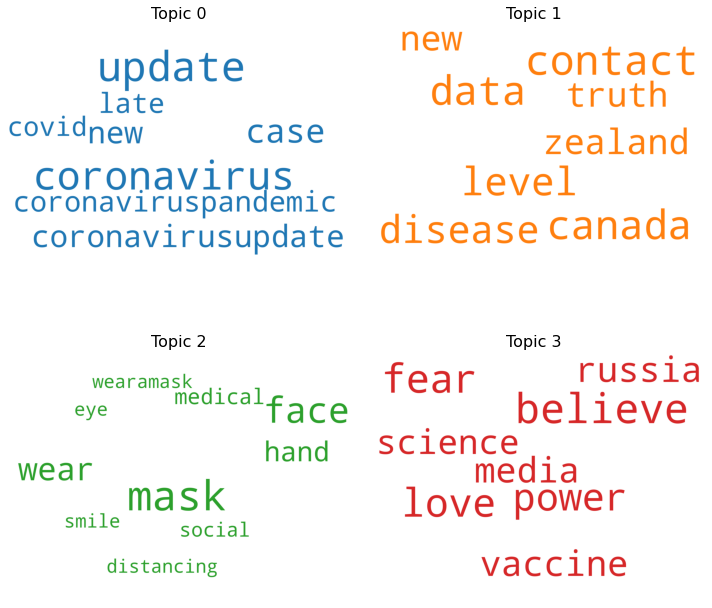

In [79]:
custom_stop = ["friday", "aug", "gmt", "august", "grow", "happen"]
cloud(lda_opt_total, custom_stop)

In [ ]:
cloud(lda_model_tfidf, custom_stop)

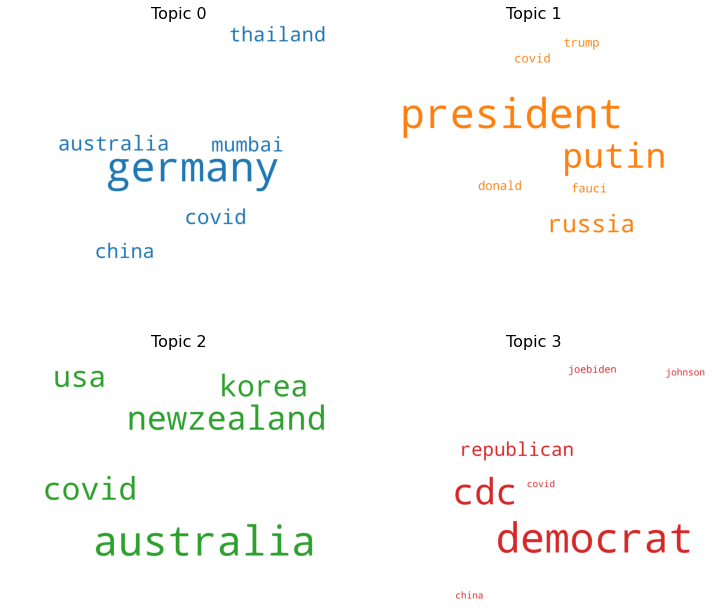

In [92]:
# beaucoup de stopwords ici quand même
# qualité du modèle/corpus ?
custom_stop = ["realdonaldtrump" ,
               "new", "zealand", "nigeria",
               "icymi", "pushpin", "amp",
               "august", "victoria", "biden",
              "delhi", "europe"]
cloud(lda_tfidf_propn, custom_stop)

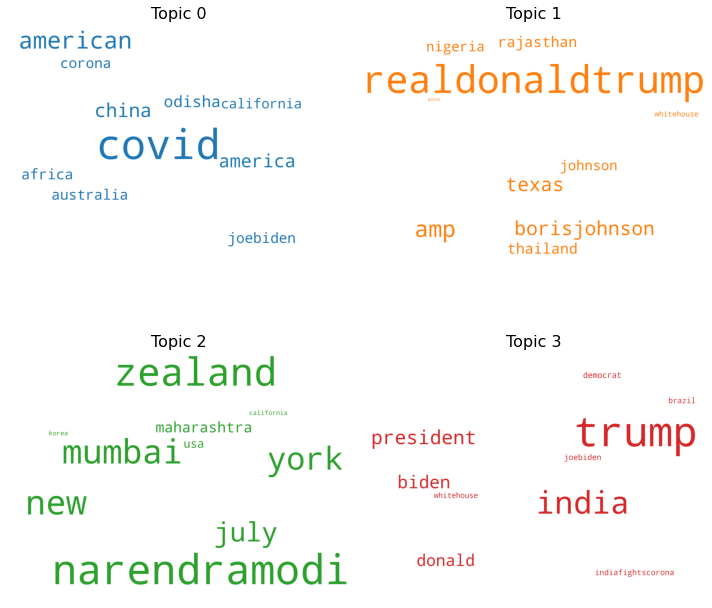

In [95]:
# beaucoup de stopwords ici quand même
# qualité du modèle/corpus ?
custom_stop = []
cloud(lda_tfidf_propn_lt, custom_stop)

In [33]:
#visualize with pyLDAvis
import warnings
# pyLDAvis is creating warnings everywhere....
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_tfidf, docs_corpus, dictionary=lda_model_tfidf.id2word)
vis
warnings.filterwarnings("ignore") 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.112006  0.049745       1        1  22.230866
4      0.162367 -0.045122       2        1  18.626959
3     -0.303985 -0.204972       3        1  16.104864
5      0.131530 -0.015181       4        1  15.848534
0      0.124447 -0.027845       5        1  15.485249
2     -0.226365  0.243375       6        1  11.703528, topic_info=        Term         Freq        Total Category  logprob  loglift
54      case  3894.000000  3894.000000  Default  30.0000  30.0000
163    total  1377.000000  1377.000000  Default  29.0000  29.0000
30     death  2631.000000  2631.000000  Default  28.0000  28.0000
205      new  2999.000000  2999.000000  Default  27.0000  27.0000
180   report  1718.000000  1718.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
30     death   289.482958  2631.639017   Topic6  -5.1532  -0.0620
94    update   258.094096  1329.717686   Topic6  -5.2680   0.5059
236  testing   224.440142   653.673617   Topic6  -5.4077   1.0763
127      amp   247.811417  1642.007092   Topic6  -5.3086   0.2543
251    world   222.392402  1110.756620   Topic6  -5.4169   0.5369

[413 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
633       1  0.121440     able
633       2  0.102391     able
633       4  0.071435     able
633       5  0.002381     able
633       6  0.704828     able
...     ...       ...      ...
169       4  0.240235     year
169       5  0.324762     year
169       6  0.056722     year
731       6  0.996362     york
3198      3  0.996953  zealand

[777 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 6, 1, 3])

In [48]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# sentiment analysis
# importing the analyser :
analyser = SentimentIntensityAnalyzer()

# Map:
df["sentiment"] = df.c_text.progress_map(analyser.polarity_scores)
# takes 11 seconds ahah

  0%|          | 0/179108 [00:00<?, ?it/s]

In [49]:
df[[elem for elem in df.columns[9:]]].head(10)

,text,hashtags,source,c_text,sentiment
0,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,if i smelled the scent of hand sanitizers toda...,"{'neg': 0.0, 'neu': 0.868, 'pos': 0.132, 'comp..."
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,hey yankees yankeespr and mlb wouldnt it have ...,"{'neg': 0.062, 'neu': 0.837, 'pos': 0.101, 'co..."
2,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,diane wdunlap realdonaldtrump trump never once...,"{'neg': 0.11, 'neu': 0.89, 'pos': 0.0, 'compou..."
3,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,brookbanktv the one gift covid has give me is ...,"{'neg': 0.0, 'neu': 0.744, 'pos': 0.256, 'comp..."
4,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,july media bulletin on novel coronavirusupdat...,"{'neg': 0.0, 'neu': 0.813, 'pos': 0.187, 'comp..."
5,#coronavirus #covid19 deaths continue to rise....,"['coronavirus', 'covid19']",Twitter Web App,coronavirus covid deaths continue to rise its ...,"{'neg': 0.157, 'neu': 0.78, 'pos': 0.063, 'com..."
6,How #COVID19 Will Change Work in General (and ...,"['COVID19', 'Recruiting']",Buffer,how covid will change work in general and recr...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
7,You now have to wear face coverings when out s...,NaN,TweetDeck,you now have to wear face coverings when out s...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
8,Praying for good health and recovery of @Chouh...,"['covid19', 'covidPositive']",Twitter for Android,praying for good health and recovery of chouha...,"{'neg': 0.0, 'neu': 0.597, 'pos': 0.403, 'comp..."
9,POPE AS GOD - Prophet Sadhu Sundar Selvaraj. W...,"['HurricaneHanna', 'COVID19']",Twitter for iPhone,pope as god prophet sadhu sundar selvaraj watc...,"{'neg': 0.0, 'neu': 0.84, 'pos': 0.16, 'compou..."


In [50]:
# quick way to get everything sorted
df["neg"] = df['sentiment'].apply(lambda x: x.get('neg'))
df["neu"] = df['sentiment'].apply(lambda x: x.get('neu'))
df["pos"] = df['sentiment'].apply(lambda x: x.get('pos'))
df["compound"] = df['sentiment'].apply(lambda x: x.get('compound'))

In [51]:
df[[elem for elem in df.columns[9:]]].head(10)

,text,hashtags,source,c_text,sentiment,neg,neu,pos,compound
0,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,if i smelled the scent of hand sanitizers toda...,"{'neg': 0.0, 'neu': 0.868, 'pos': 0.132, 'comp...",0.000,0.868,0.132,0.4939
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,hey yankees yankeespr and mlb wouldnt it have ...,"{'neg': 0.062, 'neu': 0.837, 'pos': 0.101, 'co...",0.062,0.837,0.101,0.2263
2,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,diane wdunlap realdonaldtrump trump never once...,"{'neg': 0.11, 'neu': 0.89, 'pos': 0.0, 'compou...",0.110,0.890,0.000,-0.2732
3,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,brookbanktv the one gift covid has give me is ...,"{'neg': 0.0, 'neu': 0.744, 'pos': 0.256, 'comp...",0.000,0.744,0.256,0.7351
4,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,july media bulletin on novel coronavirusupdat...,"{'neg': 0.0, 'neu': 0.813, 'pos': 0.187, 'comp...",0.000,0.813,0.187,0.3182
5,#coronavirus #covid19 deaths continue to rise....,"['coronavirus', 'covid19']",Twitter Web App,coronavirus covid deaths continue to rise its ...,"{'neg': 0.157, 'neu': 0.78, 'pos': 0.063, 'com...",0.157,0.780,0.063,-0.4445
6,How #COVID19 Will Change Work in General (and ...,"['COVID19', 'Recruiting']",Buffer,how covid will change work in general and recr...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
7,You now have to wear face coverings when out s...,NaN,TweetDeck,you now have to wear face coverings when out s...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
8,Praying for good health and recovery of @Chouh...,"['covid19', 'covidPositive']",Twitter for Android,praying for good health and recovery of chouha...,"{'neg': 0.0, 'neu': 0.597, 'pos': 0.403, 'comp...",0.000,0.597,0.403,0.6597
9,POPE AS GOD - Prophet Sadhu Sundar Selvaraj. W...,"['HurricaneHanna', 'COVID19']",Twitter for iPhone,pope as god prophet sadhu sundar selvaraj watc...,"{'neg': 0.0, 'neu': 0.84, 'pos': 0.16, 'compou...",0.000,0.840,0.160,0.2732


In [53]:
df[["neg","neu","pos","compound"]].describe()

,neg,neu,pos,compound
count,179108.000000,179108.000000,179108.000000,179108.000000
mean,0.068733,0.835926,0.095339,0.061065
std,0.107021,0.145503,0.119519,0.414359
min,0.000000,0.038000,0.000000,-0.995200
25%,0.000000,0.737000,0.000000,-0.153100
50%,0.000000,0.847000,0.000000,0.000000
75%,0.127000,1.000000,0.167000,0.401900
max,0.913000,1.000000,0.903000,0.999500


In [60]:
# find the extremes to laugh at them:

print("Tweet avec le score positif maximal :\n", df.iloc[df.pos.idxmax()].text ,"\n\n")

print("Tweet avec le score négatif maximal :\n", df.iloc[df.neg.idxmax()].text ,"\n\n")

print("Tweet avec le compound score le plus élevé :\n", df.iloc[df.compound.idxmax()].text ,"\n\n")


Tweet avec le score positif maximal :
 Wow. Pretty cool.
#COVID19 https://t.co/hJQJqlHKw6 


Tweet avec le score négatif maximal :
 Fuck fuck fuck..
#COVID19 


Tweet avec le compound score le plus élevé :
 @realDonaldTrump DID ROBERT THINK #COVID19 WAS A HOAX TOO?

🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣… https://t.co/OucVZdVBx4 


